In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, monotonically_increasing_id
from pyspark.ml.linalg import Vectors
import numpy as np
from collections import defaultdict
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder.appName("Big Data Classification").getOrCreate()
spark

In [4]:
df = spark.read.csv('BankCustomerData_Processed.csv', header=True, inferSchema=True)
df.show()

+---+-------+-------+-------+----+---+-----+--------+-----+--------+-----------+-----------------+------------------+-------------------+------------+
|age|marital|default|housing|loan|day|month|campaign|pdays|previous|job_indexed|education_indexed|balance_normalized|duration_normalized|term_deposit|
+---+-------+-------+-------+----+---+-----+--------+-----+--------+-----------+-----------------+------------------+-------------------+------------+
| 58|      2|      0|      1|   0|  5|    5|       1|   -1|       0|          1|                1|       0.849311927|        0.466905188|           0|
| 44|      1|      0|      1|   0|  5|    5|       1|   -1|       0|          2|                0|       0.364449541|        0.270125224|           0|
| 33|      2|      0|      1|   1|  5|    5|       1|   -1|       0|          7|                0|       0.358256881|        0.135957066|           0|
| 47|      2|      0|      1|   0|  5|    5|       1|   -1|       0|          0|              

In [7]:
# Thêm cột id để đảm bảo sắp xếp không thay đổi
df = df.withColumn("id", monotonically_increasing_id())

train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Chọn các cột tính năng
feature_cols = [col for col in df.columns if col != 'term_deposit' and col != 'id']

# Sử dụng VectorAssembler để tạo cột features từ các cột tính năng
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

# Chọn cột features và term_deposit để sử dụng trong quá trình tính toán
train_data = train_data.select("id", "features", "term_deposit")
test_data = test_data.select("id", "features")
train_data.show()

+-----+--------------------+------------+
|   id|            features|term_deposit|
+-----+--------------------+------------+
|42146|[18.0,1.0,0.0,0.0...|           0|
|41487|[18.0,1.0,0.0,0.0...|           1|
|40736|[18.0,1.0,0.0,0.0...|           0|
|40887|[18.0,1.0,0.0,0.0...|           1|
|42274|[18.0,1.0,0.0,0.0...|           1|
|41252|[18.0,1.0,0.0,0.0...|           0|
|31492|[19.0,1.0,0.0,0.0...|           1|
|41402|[19.0,1.0,0.0,0.0...|           0|
|34288|[19.0,1.0,0.0,0.0...|           0|
|34281|[19.0,1.0,0.0,0.0...|           0|
|31263|[19.0,1.0,0.0,0.0...|           0|
|34675|[19.0,1.0,0.0,0.0...|           0|
|30791|[19.0,1.0,0.0,0.0...|           0|
|41706|[19.0,1.0,0.0,0.0...|           0|
|41500|[19.0,1.0,0.0,0.0...|           0|
|40564|[19.0,1.0,0.0,0.0...|           1|
|31041|[19.0,1.0,0.0,0.0...|           0|
|40927|[19.0,1.0,0.0,0.0...|           0|
|42488|[19.0,1.0,0.0,0.0...|           0|
|32169|[19.0,1.0,0.0,0.0...|           0|
+-----+--------------------+------

In [ ]:
def euclidean_distance(v1, v2):
    return np.sqrt(np.sum((np.array(v1) - np.array(v2)) ** 2))

# Hàm tính khoảng cách và tìm k láng giềng gần nhất
def compute_distances(test_point, train_data_parttion, k):
    neighbors = []
    for train_point in train_data_partitions:
        distance = euclidean_distance(test_point.features, train_point.features)
        neighbors.append((train_point.term_deposit, distance))
    neighbors.sort(key=lambda x: x[1])
    return neighbors[:k]
    

In [ ]:
# Thực hiện Map Phase để tính toán khoảng cách và tìm k láng giềng gần nhất
def map_phase(partition, test_data_broadcast, k):
    test_data = test_data_broadcast.value
    results = []
    for test_point in test_data:
        neighbors = compute_distances(test_point, partition, k)
        results.append((test_point.id, neighbors))
    return results

In [ ]:
# Khởi tạo ma trận CDreducer
def initialize_CDreducer(test_data_size, k):
    CDreducer = defaultdict(lambda: [(float('inf'), None)] * k)
    return CDreducer

# Cập nhật ma trận CDreducer
def update_CDreducer(nearest_neighbors, CDreducer):
    for point_id, neighbors in nearest_neighbors.collect():
        current_neighbors = CDreducer[point_id]
        for neighbor in neighbors:
            for i, (dist, _) in enumerate(current_neighbors):
                if neighbor[1] < dist:
                    current_neighbors.insert(i, neighbor)
                    current_neighbors.pop()
                    break

# Thực hiện bầu chọn đa số để dự đoán nhãn cho tập test
def majority_vote(CDreducer):
    predictions = [(point_id, max(neighbors, key=lambda x: x[1])[0]) for point_id, neighbors in CDreducer.items()]
    return predictions

In [8]:
import time

start_time =  time.time()

# Chia dữ liệu huấn luyện thành các phần nhỏ
num_partitions = 4
train_data_partitions = train_data.repartition(num_partitions)

# Broadcast tập test_data để truy cập từ các worker
test_data_broadcast = spark.sparkContext.broadcast(test_data.collect())

# Số lượng láng giềng gần nhất cần tìm
k = 5

# Thực hiện Map Phase
mapped_data = train_data_partitions.rdd.mapPartitions(lambda partition: map_phase(partition, test_data_broadcast, k))

# Khởi tạo ma trận CDreducer
CDreducer = initialize_CDreducer(test_data.count(), k)

# Cập nhật ma trận CDreducer
update_CDreducer(mapped_data, CDreducer)

# Thực hiện bầu chọn đa số để dự đoán nhãn cho tập test
predictions = majority_vote(CDreducer)

end_time = time.time()


In [8]:

# Chuyển đổi predictions thành DataFrame
predictions_df = spark.createDataFrame(predictions, ["id", "prediction"])

# Thêm nhãn thực tế vào các dự đoán
test_data_with_labels = test_data.join(df.select("id", "term_deposit"), on="id", how="inner")
predictions_with_labels = predictions_df.join(test_data_with_labels, on="id", how="inner")


accuracy = predictions_with_labels.filter(predictions_with_labels.prediction == predictions_with_labels.term_deposit).count() / predictions_with_labels.count()
print(f"Accuracy: {accuracy}")
print(f"Time running: {end_time - start_time}s")

# Tạo ma trận nhầm lẫn
confusion_matrix = predictions_with_labels.groupBy("term_deposit", "prediction").count()
confusion_matrix.show()
# Dừng SparkSession
spark.stop()

Accuracy: 0.8638602251407129
Time running: 3667s
+------------+----------+-----+
|term_deposit|prediction|count|
+------------+----------+-----+
|           1|         0|  608|
|           0|         0| 7249|
|           0|         1|  553|
|           1|         1|  118|
+------------+----------+-----+



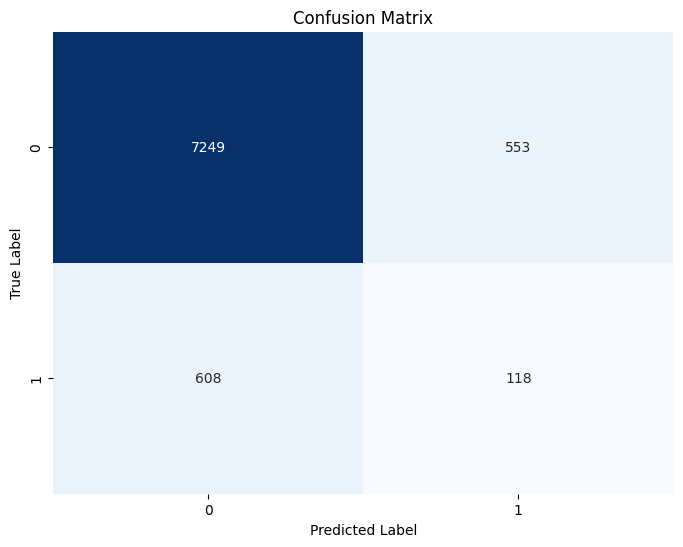

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()